# DS Practicum 1

## Question 1

**Problem:**

## Question 2

**Loading Data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV with the correct filename
df = pd.read_csv("2019_ONTIME_REPORTING_FSW-1.csv")

# View the first 5 rows
df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828.0,0.0,1353.0,0.0,205.0,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907.0,0.0,2159.0,0.0,112.0,602
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904.0,104.0,2016.0,101.0,192.0,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729.0,4.0,2215.0,3.0,166.0,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656.0,0.0,841.0,0.0,285.0,1947


**Inspecting Data and Converting to Suitable Types**

In [2]:
# inspect the dimensions
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# inspect data types
df.info()

There are 1897503 rows and 14 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897503 entries, 0 to 1897502
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   FL_DATE       object 
 1   CARRIER_CODE  object 
 2   TAIL_NUM      object 
 3   FL_NUM        int64  
 4   ORIGIN        object 
 5   ORIGIN_ST     object 
 6   DEST          object 
 7   DEST_ST       object 
 8   DEP_TIME      float64
 9   DEP_DELAY     float64
 10  ARR_TIME      float64
 11  ARR_DELAY     float64
 12  ELAPSED_TIME  float64
 13  DISTANCE      int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 202.7+ MB


**Dimensions** <br></br>There are 1897503 rows and 14 columns of data.  

**Changes in Data Types**
<br></br>
CARRIER_CODE, TAIL_NUM, FL_NUM, ORIGIN, ORIGIN_ST, DEST, and DEST_ST will be changed to category variables because they represent labels.  FL_DATE will be changed to datetime because it represents a date.  DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, and ELAPSED_TIME will be changed to integers as well.

In [3]:
# change FL_DATE to datetime
df["FL_DATE"] = pd.to_datetime(df["FL_DATE"])

# change CARRIER_CODE, TAIL_NUM, FL_NUM, ORIGIN, ORIGIN_ST, DEST, DEST_ST to
# categorical variables
df["FL_NUM"] = df["FL_NUM"].astype("category")
df["CARRIER_CODE"] = df["CARRIER_CODE"].astype("category")
df["TAIL_NUM"] = df["TAIL_NUM"].astype("category")
df["ORIGIN"] = df["ORIGIN"].astype("category")
df["ORIGIN_ST"] = df["ORIGIN_ST"].astype("category")
df["DEST"] = df["DEST"].astype("category")
df["DEST_ST"] = df["DEST_ST"].astype("category")

# change DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, ELAPSED_TIME to Int64
df["DEP_TIME"] = df["DEP_TIME"].astype("Int64")
df["DEP_DELAY"] = df["DEP_DELAY"].astype("Int64")
df["ARR_TIME"] = df["ARR_TIME"].astype("Int64")
df["ARR_DELAY"] = df["ARR_DELAY"].astype("Int64")
df["ELAPSED_TIME"] = df["ELAPSED_TIME"].astype("Int64")

# verify changes 
df.dtypes

FL_DATE         datetime64[ns]
CARRIER_CODE          category
TAIL_NUM              category
FL_NUM                category
ORIGIN                category
ORIGIN_ST             category
DEST                  category
DEST_ST               category
DEP_TIME                 Int64
DEP_DELAY                Int64
ARR_TIME                 Int64
ARR_DELAY                Int64
ELAPSED_TIME             Int64
DISTANCE                 int64
dtype: object

In [4]:
# verify changes by checking first 5 rows
df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828,0,1353,0,205,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907,0,2159,0,112,602
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904,104,2016,101,192,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729,4,2215,3,166,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656,0,841,0,285,1947


In [5]:
# percentage of missing values
df.isnull().mean()*100

FL_DATE         0.000000
CARRIER_CODE    0.000000
TAIL_NUM        0.252490
FL_NUM          0.000000
ORIGIN          0.000000
ORIGIN_ST       0.000000
DEST            0.000000
DEST_ST         0.000000
DEP_TIME        1.407481
DEP_DELAY       1.407903
ARR_TIME        1.488482
ARR_DELAY       1.680314
ELAPSED_TIME    1.680314
DISTANCE        0.000000
dtype: float64

In [6]:
# distribution of missing values in rows
df.isnull().sum(axis=1).sort_values(ascending=False)

33745      6
1369812    6
1163400    6
717776     6
461086     6
          ..
636507     0
636506     0
636504     0
636503     0
1897502    0
Length: 1897503, dtype: int64

**Missing Values**<br></br>Based on this information, missing data is not widespread since only a small percentage of rows have missing data.  Out of the rows with missing data, most have 5 or 6 missing columns.  Since the columns with missing values are related to arrival, departure, and delay times and this is important to the data science question on air traffic in part 1, these rows should be dropped.

In [7]:
# remove rows with null values
df = df.dropna()

# verify changes (only rows with 0 null values retained)
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts()

0    1865619
Name: count, dtype: int64

**Invalid Data**

Invalid times of 2400 for DEP_TIME were corrected by changing them to 0 and updating the FL_DATE by 1 day.  Rows with times of 2400 were not excluded since the data is not necessarily incorrect, just inconsistent since 2400 means 24 hours later or the next day.  This means the flight actually departed at midnight the next day.

In [8]:
# determine number of rows with invalid DEP_TIME
invalid_dep_time_df = df[df["DEP_TIME"] == 2400]
print(f"{invalid_dep_time_df.shape[0]} rows with invalid DEP_TIME values")
# display rows with invalid departure times to verify later
invalid_dep_time_df.head()

241 rows with invalid DEP_TIME values


,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
34864,2019-10-07,DL,N383DZ,487,LAS,NV,ATL,GA,2400,1,635,0,215,1747
40416,2019-10-08,AA,N825NN,1542,PHX,AZ,DCA,VA,2400,0,707,0,247,1979
50938,2019-10-10,DL,N841MH,1362,LAX,CA,JFK,NY,2400,5,817,0,317,2475
65478,2019-10-13,NK,N627NK,456,LAS,NV,ORD,IL,2400,0,517,0,197,1514
68336,2019-10-14,DL,N844MH,1362,LAX,CA,JFK,NY,2400,5,803,0,303,2475


There are 241 rows with invalid departure times.

In [9]:
# update rows with invalid DEP_TIME
dep_time_filter = df["DEP_TIME"] == 2400
df.loc[dep_time_filter, ["DEP_TIME", "FL_DATE"]] = (
    df.loc[dep_time_filter].assign(DEP_TIME=0, FL_DATE=lambda x: x["FL_DATE"] + pd.DateOffset(days=1))
)

# verify changes by checking that there are no rows with 2400 as DEP_TIME
new_dep_time_df = df[df["DEP_TIME"] == 2400]
print(f"{new_dep_time_df.shape[0]} rows with invalid DEP_TIME values")

# verify changes by checking that rows in dep_time_filter now have corrected dates
verify_dep_time_cleaning = invalid_dep_time_df.merge(df, on=["FL_NUM", "TAIL_NUM", "ARR_TIME", "DEP_DELAY"], how="inner", suffixes=("_before", "_cleaned"))
verify_dep_time_cleaning = verify_dep_time_cleaning[["FL_DATE_before", "DEP_TIME_before", "FL_DATE_cleaned", "DEP_TIME_cleaned"]]
verify_date_change = (verify_dep_time_cleaning["FL_DATE_cleaned"] - verify_dep_time_cleaning["FL_DATE_before"]).dt.days
verify_dep_change = verify_dep_time_cleaning["DEP_TIME_cleaned"] == 0
print("All dates with 2400 departure time corrected by 1 day: ", (verify_date_change == 1).all())
print("All dates with 2400 departure time corrected to 0: ", (verify_dep_change).all())

0 rows with invalid DEP_TIME values
All dates with 2400 departure time corrected by 1 day:  True
All dates with 2400 departure time corrected to 0:  True


There are now 0 rows with invalid departure times.

The other columns were checked for potential invalid data but no such values were found.  Checked for invalid CARRIER_CODE (not exactly two characters), FL_NUM(not exactly 1 to 4 digits), ORIGIN/DEST (not exactly 3 uppercase letters), ORIGIN_ST/DEST_ST (not exactly 2 uppercase letters), and DISTANCE (negative distances).  

**Additional Variable Checks**

In [10]:
# check for invalid CARRIER_CODE (not two characters)
carrier_code_check = df["CARRIER_CODE"].str.len() != 2
carrier_code_check_df = df[carrier_code_check]
print(f"There are {carrier_code_check_df.shape[0]} CARRIER_CODE entries that are not 2 characters")

There are 0 CARRIER_CODE entries that are not 2 characters


There are no CARRIER_CODE entries with IDs that are not 2 characters.

In [11]:
# check for invalid FL_NUM (not 1 to 4 digits)
fl_num_check = (df["FL_NUM"].astype("string").str.len() > 4) |  (df["FL_NUM"].astype("string").str.len() == 0)
fl_num_check_df = df[fl_num_check]
print(f"There are {fl_num_check_df.shape[0]} FL_NUM entries that are not 1 to 4 digits")

There are 0 FL_NUM entries that are not 1 to 4 digits


There are no FL_NUM entries with values that are not 1 to 4 characters.

In [12]:
# check for invalid ORIGIN/DEST that does not have 3 characters
origin_check = df["ORIGIN"].astype("string").str.len() != 3
origin_check_df = df[origin_check]
print(f"There are {origin_check_df.shape[0]} ORIGIN entries that are not 3 characters.")
dest_check = df["DEST"].astype("string").str.len() != 3
dest_check_df = df[dest_check]
print(f"There are {dest_check_df.shape[0]} DEST entries that are not 3 characters.")

There are 0 ORIGIN entries that are not 3 characters.
There are 0 DEST entries that are not 3 characters.


There are no ORIGIN or DEST entries with values that are not 3 characters long.

In [13]:
# check for invalid ORIGIN_ST/DEST_ST that does not have 2 characters
originst_check = df["ORIGIN_ST"].astype("string").str.len() != 2
originst_check_df = df[originst_check]
print(f"There are {originst_check_df.shape[0]} ORIGIN_ST entries that are not 2 characters.")
destst_check = df["DEST_ST"].astype("string").str.len() != 2
destst_check_df = df[destst_check]
print(f"There are {destst_check_df.shape[0]} DEST_ST entries that are not 2 characters.")

There are 0 ORIGIN_ST entries that are not 2 characters.
There are 0 DEST_ST entries that are not 2 characters.


There are no ORIGIN_ST or DEST_ST entries with values that are not 3 characters long.

In [14]:
# check for invalid DISTANCE that is negative
dist_check = df["DISTANCE"] < 0
dist_check_df = df[dist_check]
print(f"There are {dist_check_df.shape[0]} DISTANCE entries with negative values")

There are 0 DISTANCE entries with negative values


There are no DISTANCE entries that have negative values

**High Level Overview of Dataset: Airline Carriers and Delays**

In [15]:
print(f"There are {df['CARRIER_CODE'].unique().size} different airline carriers")

There are 15 different airline carriers


In [16]:
# create new data frame with just carrier codes and delays
carrier_delay_df_avg = df.groupby("CARRIER_CODE", observed=True)[["ARR_DELAY", "DEP_DELAY"]].mean()
carrier_delay_df_std = df.groupby("CARRIER_CODE", observed=True)[["ARR_DELAY", "DEP_DELAY"]].std()
carrier_delay_df_avg.head()


,ARR_DELAY,DEP_DELAY
CARRIER_CODE,,
AA,14.663912,14.611223
AS,11.912299,10.724285
B6,16.052948,16.466444
DL,10.501713,10.802896
EV,13.244681,11.62766


**Visual 1-2**

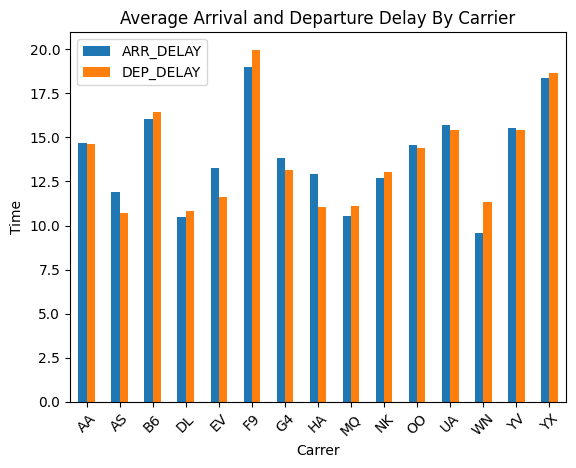

In [17]:
# visualize results
carrier_delay_df_avg.plot(y=["ARR_DELAY", "DEP_DELAY"], kind="bar")
plt.title("Average Arrival and Departure Delay By Carrier")
plt.ylabel("Time")
plt.xlabel("Carrer")
plt.xticks(rotation=45)
plt.show()

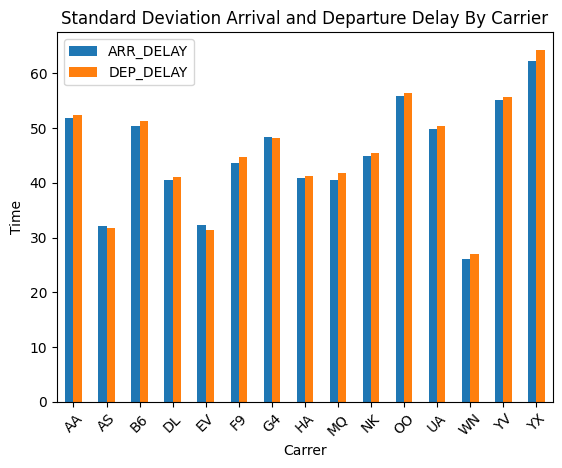

In [18]:
carrier_delay_df_std.plot(y=["ARR_DELAY", "DEP_DELAY"], kind="bar")
plt.title("Standard Deviation Arrival and Departure Delay By Carrier")
plt.ylabel("Time")
plt.xlabel("Carrer")
plt.xticks(rotation=45)
plt.show()

**Analysis**
<br></br>
Based on the average delay data, carriers F9, YX, and B6 are the most prone to arrival along with departure delays.  The carriers with the least delays are DL, WN, and MO.  Examining the standard devation of delays across carriers shows that the carrier with the greatest variation in arrival and departure delays is YX.  The carrier with the least variability in terms of delays is VW.  Therefore, VW flights tend to have lower delays and have more consistent delay patterns.  In contrast, YX flights tend to have greater delays and less consistent delay patterns.  Generally across airline carriers, the variability of delay patterns are similar for arrival and departure delays.  This may imply that flight carriers have similar patterns of arrival and departure delays.  

**Visuals 3-4**

**High Level Overview: Air Traffic at Certain Regions**

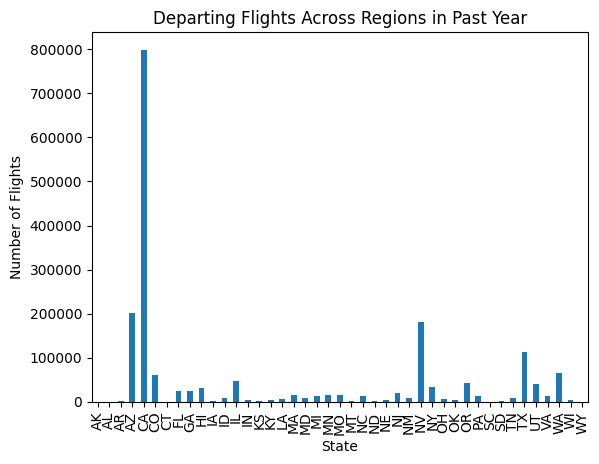

In [19]:
air_traffic_overview_departing_df = df.groupby("ORIGIN_ST", observed=True).size()
air_traffic_overview_departing_df.plot(y=["ORIGIN_ST"], kind="bar")
plt.title("Departing Flights Across Regions in Past Year")
plt.ylabel("Number of Flights")
plt.xlabel("State")
plt.show()

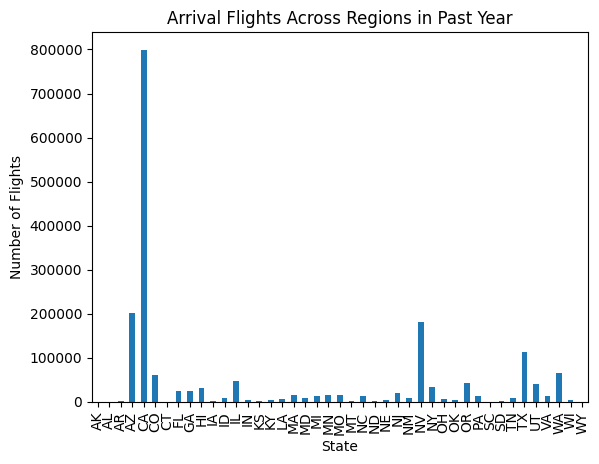

In [20]:
air_traffic_overview_arrival_df = df.groupby("DEST_ST", observed=True).size()
air_traffic_overview_arrival_df.plot(y=["DEST_ST"], kind="bar")
plt.title("Arrival Flights Across Regions in Past Year")
plt.ylabel("Number of Flights")
plt.xlabel("State")
plt.show()

**Analysis**

Based on the number of arriving and departing flights across regions in the past year worth of data, CA dominates in terms of total flights, followed by AZ and NV.  Therefore, air traffic is greatest at CA, AZ, and NV based on measures of total flights.  Several regions including AK, AL, and SC have a negligable amount of arriving and departing flights in comparison.  Therefore, these states likely have the least amount of air traffic.

**Summary Statistics**

In [21]:
avg_fl_date = df['FL_DATE'].mean()
mode_carrier_code = df['CARRIER_CODE'].mode().iloc[0]
mode_origin_st = df['ORIGIN_ST'].mode().iloc[0]
mode_dest_st = df['DEST_ST'].mode().iloc[0]
avg_dep_time = df['DEP_TIME'].mean()
avg_dep_delay = df['DEP_DELAY'].mean()
avg_arr_time = df['ARR_TIME'].mean()
avg_arr_delay = df['ARR_DELAY'].mean()
avg_distance = df['DISTANCE'].mean()
std_distance = df['DISTANCE'].std()
avg_elapsed_time = df['ELAPSED_TIME'].mean()
std_elapsed_time = df['ELAPSED_TIME'].std()

print(f"mean flight date: {avg_fl_date}")
print(f"mode carrier code: {mode_carrier_code}")
print(f"mode origin: {mode_origin_st}")
print(f"mode destination: {mode_dest_st}")
print(f"average departure time: {avg_dep_time}")
print(f"average departure delay: {avg_dep_delay}")
print(f"average arrival time: {avg_arr_time}")
print(f"average arrival delay: {avg_arr_delay}")
print(f"average distance: {avg_distance}")
print(f"std distance: {std_distance}")
print(f"average elapsed time: {avg_elapsed_time}")
print(f"std elapsed time: {std_elapsed_time}")

mean flight date: 2019-07-03 20:16:25.212092928
mode carrier code: WN
mode origin: CA
mode destination: CA
average departure time: 1341.0772821245923
average departure delay: 13.115671527787828
average arrival time: 1470.2079004341188
average arrival delay: 12.723572176312526
average distance: 1146.8583794440344
std distance: 756.4240752958344
average elapsed time: 174.80958866735384
std elapsed time: 92.73538957180202


Based on the summary statistics, the average flight date was 7/3/2019, indicating that the flight data has a relatively even spread since July is close to the middle of the year.  The most common carrier code was WN, which based on the previous data on delays, seems to have some of the lowest arrival and departure delays compared to other carriers.  Therefore, WN seems to be the least prone to delays and a popular flight choice.  The mode origin and destination are both CA, indicating that there is likely high air traffic in this region due to the number of incoming as well as outgoing flights.  The average departure and arrival times make sense since the average departure time is lower than the average arrival time.  Both arrival and departure times tend to have a similar average delay, which was also reflected in the previous charts.  The average distance is 1146.86 and this can vary by about 756.42 based on the standard deviation.  This can be reviewed on a region basis since longer average distances might indicate the presense of more international flights at an airport.  Lower average distances might indicate a more regional airport with high or low traffic based on other measures like the number of arriving or departing flights. The average elapsed time is 174.81 and the standard deviation of this time is 92.73.  Similar to the distances, this can be reviewed on a region basis to further determine air traffic at specific locations.

## Question 3

1. Explore patterns in the region i.e. the 3 states (AZ, NV, CA). Determine which region has the most air traffic. Comment on your findings and visualize the results. Note: it's important to explain your rational for determining what is "the most air traffic". For example, are you evaluating the frequency of flights or total flight time. Justify your response.

In [22]:
# filter data for AZ, NV, and CA
states = ['AZ', 'NV', 'CA']
state_filter = df['ORIGIN_ST'].isin(states) | df['DEST_ST'].isin(states)
filtered_df = df[state_filter]
# verify results by checking how many rows don't have an original location or destination of one of the specified states
invalidRows = filtered_df[~df['ORIGIN_ST'].isin(states) & ~df['DEST_ST'].isin(states)].shape[0]
print(f"There are {invalidRows} rows without an original location or destination of AZ, NV, or CA")

There are 0 rows without an original location or destination of AZ, NV, or CA


In [23]:
# determine time span of data
filtered_df['FL_DATE'].value_counts(ascending=True)

FL_DATE
2020-01-01       1
2019-11-28    3547
2019-01-19    3822
2019-02-02    3829
2019-02-09    3980
              ... 
2019-08-08    5628
2019-08-16    5647
2019-08-12    5661
2019-08-05    5675
2019-08-09    5693
Name: count, Length: 366, dtype: int64

**Criteria For Most Air Traffic**
<br></br>
The region with the most air traffice will be determined by analyzing the frequency of flights that have arrived at that region and the frequency of flights that have departed from that region between August 9, 2019 and January 1, 2020.  The number of incoming and outgoing flights per day from each region will be analyzed in particular.

In [24]:
# airport data from AZ
az_filter = df['ORIGIN_ST'].isin(['AZ']) | df['DEST_ST'].isin(['AZ'])
az_airport_df = filtered_df[az_filter]
az_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
0,2019-10-01,AA,N916NN,2311,TUS,AZ,ORD,IL,828,0,1353,0,205,1437
1,2019-10-01,AA,N733UW,2315,PHX,AZ,DEN,CO,1907,0,2159,0,112,602
5,2019-10-01,AA,N816NN,2339,PHX,AZ,JFK,NY,911,0,1702,0,291,2153
10,2019-10-01,AA,N982AN,2369,JFK,NY,PHX,AZ,1053,0,1250,0,297,2153
11,2019-10-01,AA,N177US,2371,EWR,NJ,PHX,AZ,941,0,1155,0,314,2133


In [25]:
# number of flights that arrived at AZ in past year
az_airport_df_arrival = az_airport_df[az_airport_df["DEST_ST"] == 'AZ']
print(f"{az_airport_df_arrival.shape[0]} flights arrived at AZ in past year")

201744 flights arrived at AZ in past year


In [26]:
# count number of flights per day that arrive at AZ
az_arrival_flights_per_day = az_airport_df_arrival.groupby("FL_DATE").size()

**AZ Arrival Flights Per Day Statistics**

In [27]:
# calculate statistics for flight frequencies
az_mean_arrival_flights = az_arrival_flights_per_day.mean()
az_median_arrival_flights = az_arrival_flights_per_day.median()
az_mode_arrival_flights = az_arrival_flights_per_day.mode().iloc[0]
az_std_arrival_flights = az_arrival_flights_per_day.std()
print("AZ Arrival Flights Per Day Statistics:")
print(f"mean: {az_mean_arrival_flights}")
print(f"median: {az_median_arrival_flights}")
print(f"mode: {az_mode_arrival_flights}")
print(f"std: {az_std_arrival_flights}")

AZ Arrival Flights Per Day Statistics:
mean: 552.7232876712329
median: 556.0
mode: 576
std: 42.88923415898145


In [28]:
# number of flights that departed from AZ in past year
az_airport_df_departure = az_airport_df[az_airport_df["ORIGIN_ST"] == 'AZ']
print(f"{az_airport_df_departure.shape[0]} flights departed from AZ in past year")

201804 flights departed from AZ in past year


In [29]:
# count number of flights per day that depart from AZ
az_departure_flights_per_day = az_airport_df_departure.groupby("FL_DATE").size()

**AZ Departure Flights Per Day Statistics**

In [30]:
# calculate statistics for flight frequencies
az_mean_departure_flights = az_departure_flights_per_day.mean()
az_median_departure_flights = az_departure_flights_per_day.median()
az_mode_departure_flights = az_departure_flights_per_day.mode().iloc[0]
az_std_departure_flights = az_departure_flights_per_day.std()
print("AZ Departure Flights Per Day Statistics:")
print(f"mean: {az_mean_departure_flights}")
print(f"median: {az_median_departure_flights}")
print(f"mode: {az_mode_departure_flights}")
print(f"std: {az_std_departure_flights}")

AZ Departure Flights Per Day Statistics:
mean: 552.8876712328768
median: 556.0
mode: 571
std: 42.849096138560675


In [31]:
# airport data from NV
nv_filter = df['ORIGIN_ST'].isin(['NV']) | df['DEST_ST'].isin(['NV'])
nv_airport_df = filtered_df[nv_filter]
nv_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
14,2019-10-01,AA,N352PS,2390,DFW,TX,LAS,NV,2225,0,2310,0,165,1055
16,2019-10-01,AA,N953NN,2407,LAS,NV,ORD,IL,1143,0,1716,0,213,1514
22,2019-10-01,AA,N922AN,2427,ORD,IL,RNO,NV,1216,0,1432,0,256,1671
23,2019-10-01,AA,N922AN,2427,RNO,NV,ORD,IL,1523,0,2143,18,260,1671
28,2019-10-01,AA,N305NX,2448,DFW,TX,RNO,NV,1722,0,1839,0,197,1345


In [32]:
# number of flights that arrived at NV in past year
nv_airport_df_arrival = nv_airport_df[nv_airport_df["DEST_ST"] == 'NV']
print(f"{nv_airport_df_arrival.shape[0]} flights arrived at NV in past year")

182115 flights arrived at NV in past year


In [33]:
# count number of flights per day that arrive at NV
nv_arrival_flights_per_day = nv_airport_df_arrival.groupby("FL_DATE").size()

**NV Arrival Flights Per Day Statistics:**

In [34]:
# calculate statistics for flight frequencies
nv_mean_arrival_flights = nv_arrival_flights_per_day.mean()
nv_median_arrival_flights = nv_arrival_flights_per_day.median()
nv_mode_arrival_flights = nv_arrival_flights_per_day.mode().iloc[0]
nv_std_arrival_flights = nv_arrival_flights_per_day.std()
print("NV Arrival Flights Per Day Statistics:")
print(f"mean: {nv_mean_arrival_flights}")
print(f"median: {nv_median_arrival_flights}")
print(f"mode: {nv_mode_arrival_flights}")
print(f"std: {nv_std_arrival_flights}")

NV Arrival Flights Per Day Statistics:
mean: 498.94520547945206
median: 505.0
mode: 501
std: 43.27851610608923


In [35]:
# number of flights that departed from NV in past year
nv_airport_df_departure = nv_airport_df[nv_airport_df["ORIGIN_ST"] == 'NV']
print(f"{nv_airport_df_departure.shape[0]} flights departed from NV in past year")

181985 flights departed from NV in past year


In [36]:
# count number of flights per day that depart from NV
nv_departure_flights_per_day = nv_airport_df_departure.groupby("FL_DATE").size()

**NV Departure Flights Per Day Statistics**

In [37]:
# calculate statistics for flight frequencies
nv_mean_departure_flights = nv_departure_flights_per_day.mean()
nv_median_departure_flights = nv_departure_flights_per_day.median()
nv_mode_departure_flights = nv_departure_flights_per_day.mode().iloc[0]
nv_std_departure_flights = nv_departure_flights_per_day.std()
print("NV Departure Flights Per Day Statistics:")
print(f"mean: {nv_mean_departure_flights}")
print(f"median: {nv_median_departure_flights}")
print(f"mode: {nv_mode_departure_flights}")
print(f"std: {nv_std_departure_flights}")

NV Departure Flights Per Day Statistics:
mean: 498.5890410958904
median: 505.0
mode: 536
std: 42.593670406450784


In [38]:
# airport data from CA
ca_filter = df['ORIGIN_ST'].isin(['CA']) | df['DEST_ST'].isin(['CA'])
ca_airport_df = filtered_df[ca_filter]
ca_airport_df.head()

,FL_DATE,CARRIER_CODE,TAIL_NUM,FL_NUM,ORIGIN,ORIGIN_ST,DEST,DEST_ST,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ELAPSED_TIME,DISTANCE
2,2019-10-01,AA,N140AN,2318,DFW,TX,LAX,CA,1904,104,2016,101,192,1235
3,2019-10-01,AA,N925AN,2325,SNA,CA,DFW,TX,1729,4,2215,3,166,1205
4,2019-10-01,AA,N143AN,2328,ATL,GA,LAX,CA,656,0,841,0,285,1947
6,2019-10-01,AA,N150NN,2349,LAX,CA,BOS,MA,2149,0,559,0,310,2611
7,2019-10-01,AA,N994AN,2354,LAX,CA,DFW,TX,1128,0,1620,0,172,1235


In [39]:
# number of flights that arrived at CA in past year
ca_airport_df_arrival = ca_airport_df[ca_airport_df["DEST_ST"] == 'CA']
print(f"{ca_airport_df_arrival.shape[0]} flights arrived at CA in past year")

799137 flights arrived at CA in past year


In [40]:
# count number of flights per day that arrive at AZ
ca_arrival_flights_per_day = ca_airport_df_arrival.groupby("FL_DATE").size()

**CA Arrival Flights Per Day Statistics:**

In [41]:
# calculate statistics for flight frequencies
ca_mean_arrival_flights = ca_arrival_flights_per_day.mean()
ca_median_arrival_flights = ca_arrival_flights_per_day.median()
ca_mode_arrival_flights = ca_arrival_flights_per_day.mode().iloc[0]
ca_std_arrival_flights = ca_arrival_flights_per_day.std()
print("CA Arrival Flights Per Day Statistics:")
print(f"mean: {ca_mean_arrival_flights}")
print(f"median: {ca_median_arrival_flights}")
print(f"mode: {ca_mode_arrival_flights}")
print(f"std: {ca_std_arrival_flights}")

CA Arrival Flights Per Day Statistics:
mean: 2183.434426229508
median: 2218.5
mode: 2184
std: 223.8513690249122


In [42]:
# number of flights that departed from AZ in past year
ca_airport_df_departure = ca_airport_df[ca_airport_df["ORIGIN_ST"] == 'CA']
print(f"{ca_airport_df_departure.shape[0]} flights departed from CA in past year")

798690 flights departed from CA in past year


In [43]:
# count number of flights per day that depart from CA
ca_departure_flights_per_day = ca_airport_df_departure.groupby("FL_DATE").size()

**CA Departure Flights Per Day Statistics**

In [44]:
# calculate statistics for flight frequencies
ca_mean_departure_flights = ca_departure_flights_per_day.mean()
ca_median_departure_flights = ca_departure_flights_per_day.median()
ca_mode_departure_flights = ca_departure_flights_per_day.mode().iloc[0]
ca_std_departure_flights = ca_departure_flights_per_day.std()
print("CA Departure Flights Per Day Statistics:")
print(f"mean: {ca_mean_departure_flights}")
print(f"median: {ca_median_departure_flights}")
print(f"mode: {ca_mode_departure_flights}")
print(f"std: {ca_std_departure_flights}")

CA Departure Flights Per Day Statistics:
mean: 2188.1917808219177
median: 2226.0
mode: 2291
std: 193.2162468948397


**Visualize AZ, NV, and CA Flights Per Day**

In [45]:
flights_per_day_arrival = {
    'State': ['AZ', 'NV', 'CA'],
    'Mean': [az_mean_arrival_flights, nv_mean_arrival_flights, ca_mean_arrival_flights],
    'Median': [az_median_arrival_flights, nv_median_arrival_flights, ca_median_arrival_flights],
    'Mode': [az_mode_arrival_flights, nv_mode_arrival_flights, ca_mode_arrival_flights],
    'Std Dev': [az_std_arrival_flights, nv_std_arrival_flights, ca_std_arrival_flights]
}

flights_per_day_departure = {
    'State': ['AZ', 'NV', 'CA'],
    'Mean': [az_mean_departure_flights, nv_mean_departure_flights, ca_mean_departure_flights],
    'Median': [az_median_departure_flights, nv_median_departure_flights, ca_median_departure_flights],
    'Mode': [az_mode_departure_flights, nv_mode_departure_flights, ca_mode_departure_flights],
    'Std Dev': [az_std_departure_flights, nv_std_departure_flights, ca_std_departure_flights]
}

flights_per_day_arrival_df = pd.DataFrame(flights_per_day_arrival)
flights_per_day_departure_df = pd.DataFrame(flights_per_day_departure)

**Flights Per Day Arrival**

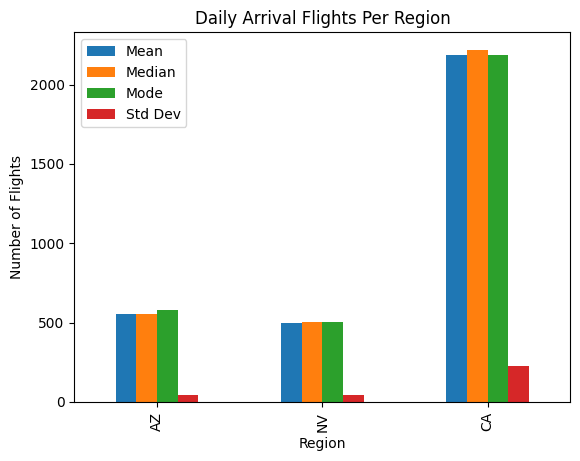

In [46]:
flights_per_day_arrival_df.index = ['AZ', 'NV', 'CA']
flights_per_day_arrival_df.plot(y=["Mean", "Median", "Mode", "Std Dev"], kind="bar")
plt.title("Daily Arrival Flights Per Region")
plt.ylabel("Number of Flights")
plt.xlabel("Region")
plt.show()

**Flights Per Day Departure**

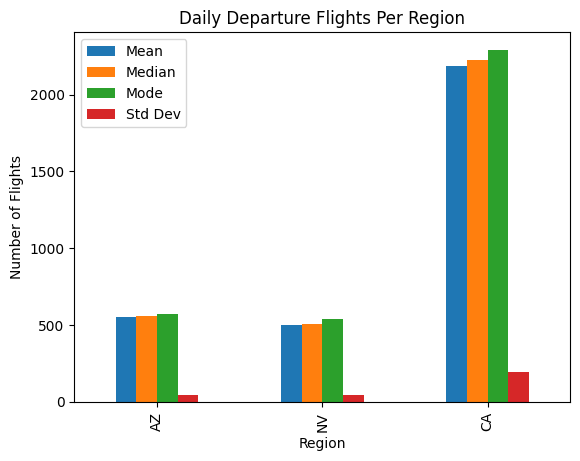

In [47]:
flights_per_day_departure_df.index = ['AZ', 'NV', 'CA']
flights_per_day_departure_df.plot(y=["Mean", "Median", "Mode", "Std Dev"], kind="bar")
plt.title("Daily Departure Flights Per Region")
plt.ylabel("Number of Flights")
plt.xlabel("Region")
plt.show()

**Analysis**

Based on the provided data, CA has the most air traffic as it has the greatest average arrival and departure flights per day.  CA has an average of 2183 arrival and and 2188 departure flights daily.  AZ has an average of 552 arrival and 552 departure flights daily, while NV has an average of 498 arrival and 498 departure flights daily.

Based on the graph results, CA clearly dominates in terms of number of flights and has a greater standard deviation, indicating more daily variability than the other two regions.  AZ and NV have similar means and medians with low standard deviations, implying more consistent day to day air traffic.  Since the mean, median, and mode are similar for all regions in terms of arrival and departure flights per day, this means that there are no extreme daily flight flight values affecting the average.

In terms of total number of flights, AZ, NV, and CA had 201744, 182115, and 798690 arrival flights in the past year respectively.  AZ, NV, and CA had 201804, 181985, and 799137 departure flights in the past year respectively.  This further proves that CA has the greatest air traffic, followed by AZ and then NV based on measures of daily fights.  


## Question 4

## Question 5

## Question 6

## Question 7